# Globe: data processing

##### Imports

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import os 
import shapefile

%matplotlib inline  
matplotlib.rcParams['figure.figsize'] = (10,10)
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.path import Path 
import matplotlib.patches as patches

## Base points
Create a 2D array of lat/long points as the basis location for the points that make up the globe

In [2]:
n_pts_lat = 180 
n_pts_long = 360 
total_n_points = n_pts_lat * n_pts_long # Start making things easy - 1 point per degree.
deg_inc_lat = 180 / n_pts_lat
deg_inc_long = 360 / n_pts_long
r = 1 # Keep the values between -1 and 1 to be easier to scale in C4D
gps_array = np.empty([n_pts_lat,n_pts_long,2]) # Latitude, Longitude
sphere_array = np.empty([n_pts_lat,n_pts_long,3]) # x,y,z of the sphere


In [3]:
for i_lat in range(0,n_pts_lat):
    for i_long in range(0,n_pts_long):
        
        gps_array[i_lat,i_long,0] = i_lat * deg_inc_lat - 90
        gps_array[i_lat,i_long,1] = i_long * deg_inc_long - 180
        
        sphere_array[i_lat,i_long,0] = r * np.cos(np.radians(gps_array[i_lat,i_long,0])) * np.cos(np.radians( gps_array[i_lat,i_long,1]))
        sphere_array[i_lat,i_long,1] = r * np.cos(np.radians(gps_array[i_lat,i_long,0])) * np.sin(np.radians( gps_array[i_lat,i_long,1]))
        sphere_array[i_lat,i_long,2] = r * np.sin(np.radians(gps_array[i_lat,i_long,0]))


In [4]:
csv_array_sphere = np.empty([1,3]) # x,y,z
csv_array_gps = np.empty([1,2]) # Latitude, longitude
for i_lat in range(0,n_pts_lat):
    for i_long in range(0,n_pts_long):
        temp_slice_sphere = np.squeeze(sphere_array[i_lat,i_long,:])
        csv_array_sphere = np.row_stack((csv_array_sphere, temp_slice_sphere)) 
        temp_slice_gps = np.squeeze(gps_array[i_lat,i_long,:])
        csv_array_gps = np.row_stack((csv_array_gps, temp_slice_gps)) 
print(csv_array_sphere)
print(csv_array_gps) 

[[ 7.50000000e-01  7.50000000e-01  0.00000000e+00]
 [-6.12323400e-17 -7.49879891e-33 -1.00000000e+00]
 [-6.12230140e-17 -1.06865168e-18 -1.00000000e+00]
 ...
 [-1.74284885e-02  9.13388380e-04  9.99847695e-01]
 [-1.74417749e-02  6.09080201e-04  9.99847695e-01]
 [-1.74497484e-02  3.04586490e-04  9.99847695e-01]]
[[ 2.12199579e-314  4.94065646e-324]
 [-9.00000000e+001 -1.80000000e+002]
 [-9.00000000e+001 -1.79000000e+002]
 ...
 [ 8.90000000e+001  1.77000000e+002]
 [ 8.90000000e+001  1.78000000e+002]
 [ 8.90000000e+001  1.79000000e+002]]


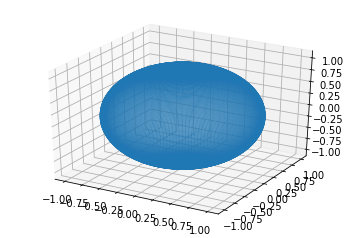

In [5]:
fig = plt.figure() 
ax = fig.add_subplot(111, projection='3d')

x = csv_array_sphere[:,0] 
y = csv_array_sphere[:,1] 
z = csv_array_sphere[:,2] 
ax.scatter(x,y,z, s=0.1)
# ax.plot_trisurf(x,y,z)



##### Load the country shapefiles to create land boundaries

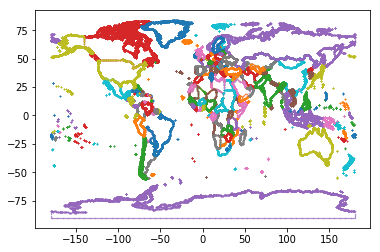

In [7]:
sf3 = shapefile.Reader('Z://Open_data_sets//World data//Borders//TM_WORLD_BORDERS-0.3.shp')
shapes = sf3.shapes()
for i in range(0,len(shapes)-1):
    curr_coords = np.asarray(shapes[i].points)
    plt.scatter(curr_coords[:,0], curr_coords[:,1], s=0.1)
#     curr_filename="county_" + str(i) + ".txt"
#     np.savetxt(curr_filename,curr_coords, fmt='%1.3f')

Note: Directly from the shapefile, the first column is longutide while the second is latitude. 

##### Plot the countires above on a sphere (not fitting to the existing grid)

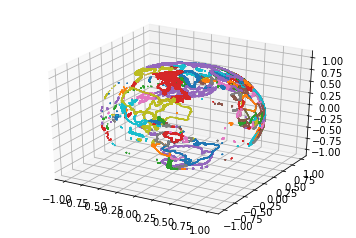

In [8]:
fig = plt.figure() 
ax = fig.add_subplot(111, projection='3d')

for i in range(0,len(shapes)-1):
    curr_coords = np.asarray(shapes[i].points)    
    x = r * np.cos(np.radians(curr_coords[:,1])) * np.cos(np.radians(curr_coords[:,0]))
    y = r * np.cos(np.radians(curr_coords[:,1])) * np.sin(np.radians(curr_coords[:,0]))
    z = r * np.sin(np.radians(curr_coords[:,1]))
    ax.scatter(x,y,z, s=0.1)

##### Using the boundaries for each country, find which base points lie inside.

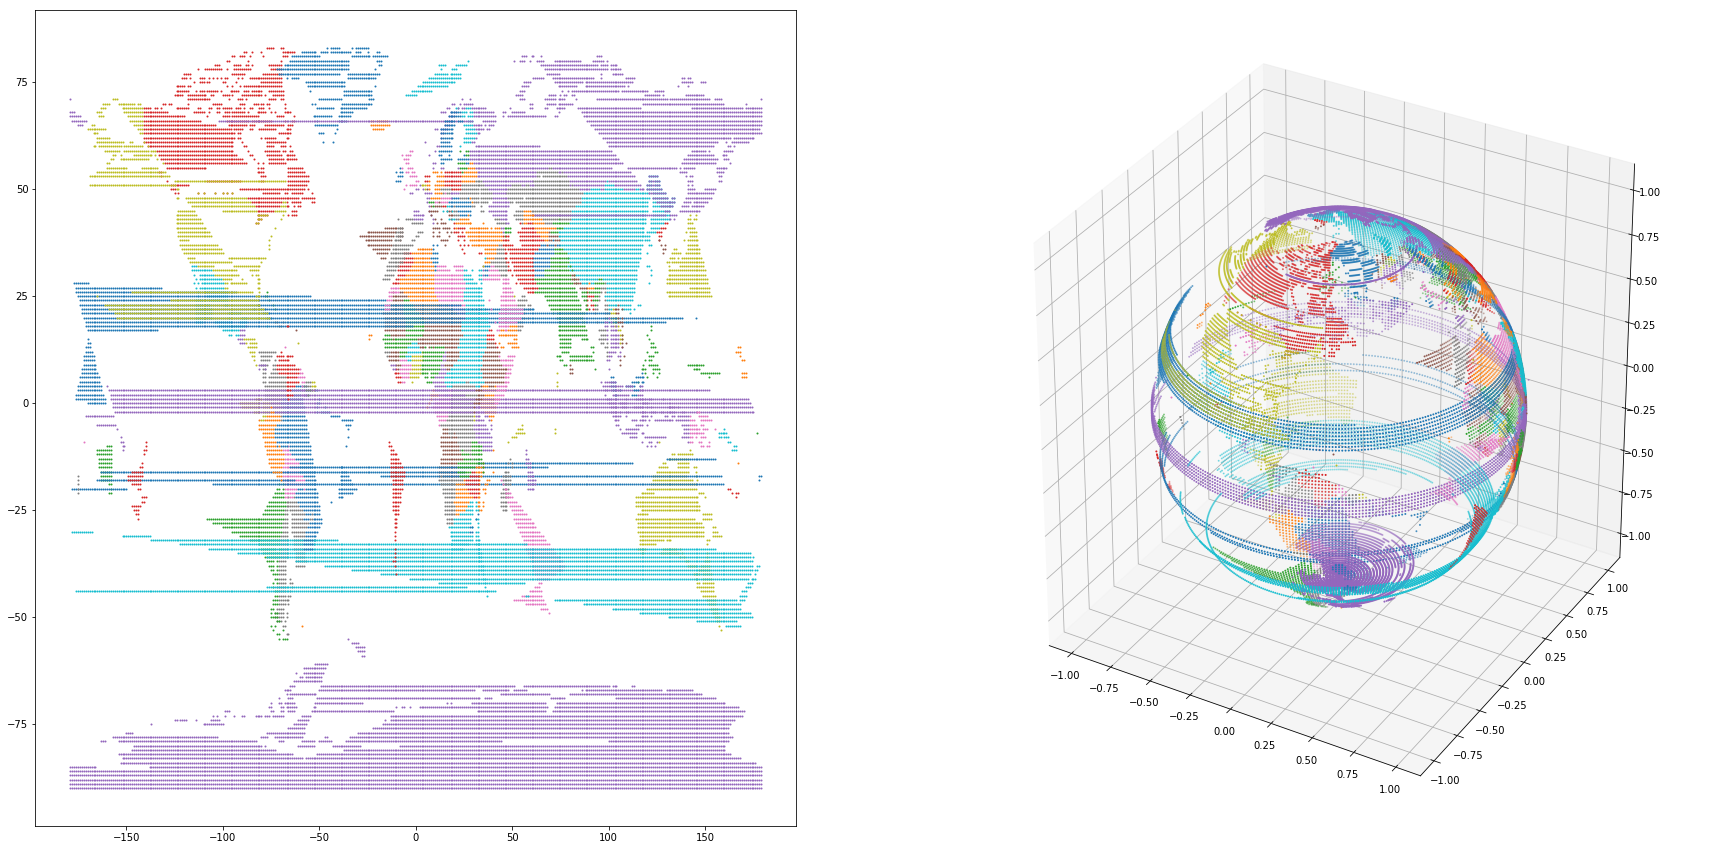

In [9]:
fig1 = plt.figure(figsize=[30,15]) 
ax1 = fig1.add_subplot(121)
ax2 = fig1.add_subplot(122, projection='3d')

for i in range(0,len(shapes)-1):
    country_array = np.fliplr(np.asarray(shapes[i].points)) # Ensures we have lAT,lONG format
    country_path = Path(country_array)

    # Find all the coordinates that fall inside the boundaries of the current country.
    mask1 = country_path.contains_points(csv_array_gps) # csv_array_gps: Latitude, longitude
    
    curr_gps_coords = csv_array_gps[mask1]
    curr_sphere_coords=csv_array_sphere[mask1]
    
    # 2D projection
    ax1.scatter(curr_gps_coords[:,1],curr_gps_coords[:,0], s=1)
    
    # Globe 3D surface
    x = curr_sphere_coords[:,0]
    y = curr_sphere_coords[:,1]
    z = curr_sphere_coords[:,2]
    ax2.scatter(x,y,z, s=1)
    
#     plt.scatter(curr_gps_coords[:,1],curr_gps_coords[:,0], s=1)
#     plt.show()

In [10]:
display(csv_array_sphere)

array([[ 7.50000000e-01,  7.50000000e-01,  0.00000000e+00],
       [-6.12323400e-17, -7.49879891e-33, -1.00000000e+00],
       [-6.12230140e-17, -1.06865168e-18, -1.00000000e+00],
       ...,
       [-1.74284885e-02,  9.13388380e-04,  9.99847695e-01],
       [-1.74417749e-02,  6.09080201e-04,  9.99847695e-01],
       [-1.74497484e-02,  3.04586490e-04,  9.99847695e-01]])

## Load static datasets and process.
Process to be in same format as the coordinates above

In [14]:
import georasters as gr

In [16]:
# Load data
raster = 'Z://Open_data_sets//World data//Population//gpw_v4_population_count_rev10_2015_30_sec.tif'
data = gr.from_file(raster)
print(type(data))
# Convert to Pandas DataFrame
df = data.to_pandas()
display(df)

# If necessary, convert dataframe to numpy array
# data_np = np.asarray(df.values)

<class 'georasters.georasters.GeoRaster'>


,row,col,value,x,y
0,224,12695,0.000001,-74.208333,83.133333
1,224,12696,0.000001,-74.200000,83.133333
2,224,12697,0.000002,-74.191667,83.133333
3,224,12698,0.000002,-74.183333,83.133333
4,224,12699,0.000002,-74.175000,83.133333
5,224,12700,0.000002,-74.166667,83.133333
6,224,12701,0.000002,-74.158333,83.133333
7,224,12702,0.000002,-74.150000,83.133333
8,224,12703,0.000002,-74.141667,83.133333
9,224,12704,0.000002,-74.133333,83.133333


##### Use datashader to aggregate the image to a canvas with the dimensions needed 

In [17]:
import datashader as ds
import datashader.transfer_functions as tf
from colorcet import fire
import matplotlib.cm as cm

cvs = ds.Canvas(plot_width=n_pts_long, plot_height=n_pts_lat)
agg = cvs.points(df, 'x', 'y', ds.mean('value'))
print(np.shape(agg), type(agg))
img = tf.shade(agg, cmap=fire, how='linear')

(180, 360) <class 'xarray.core.dataarray.DataArray'>


In [ ]:
# from PIL import Image
# display(img)
# print(np.shape(img))
# print(img[39,130]) # Roughly the center of India
# img_np = np.asarray(img)

# img2 = Image.fromarray(img_np)
# display(img2)

plt.imshow(agg)

In [18]:
population = np.empty([n_pts_lat, n_pts_long]) # Lat, Long
for i_lat in range(0,n_pts_lat):
    for i_long in range(0,n_pts_long):
        population[i_lat,i_long] = agg[i_lat,i_long]
        

In [19]:
# Now, treat the array in the same manner as done to create the csv output as above. 
csv_array_pop = np.empty([1,1]) 
for i_lat in range(0,n_pts_lat):
    for i_long in range(0,n_pts_long):
#         temp_slice_pop = sphere_array[i_lat,i_long,:]
        csv_array_pop = np.row_stack((csv_array_pop, population[i_lat,i_long])) 


# Test to confirm they have the same number of rows. 

print(np.shape(csv_array_pop ),np.shape(csv_array_sphere))

(64801, 1) (64801, 3)


#### Export the csv's'

In [23]:
export_path = 'export//'
identifier = 'latPts_'+ str(n_pts_lat)+ '_longPts_' + str(n_pts_long)
if not os.path.exists(export_path):
    os.makedirs(export_path)

np.savetxt(export_path+'sphereCoords_' + identifier + '_cs.csv',csv_array_sphere, fmt='%1.3f', delimiter=',', header='X,Y,Z')
np.savetxt(export_path+'population_' + identifier + '_cs.csv',csv_array_pop, fmt='%1.3f', delimiter=',', header='Population')
np.savetxt(export_path+'gpsCoords_' + identifier + '_cs.csv',csv_array_gps, fmt='%1.3f', delimiter=',', header='Lat,Lon')

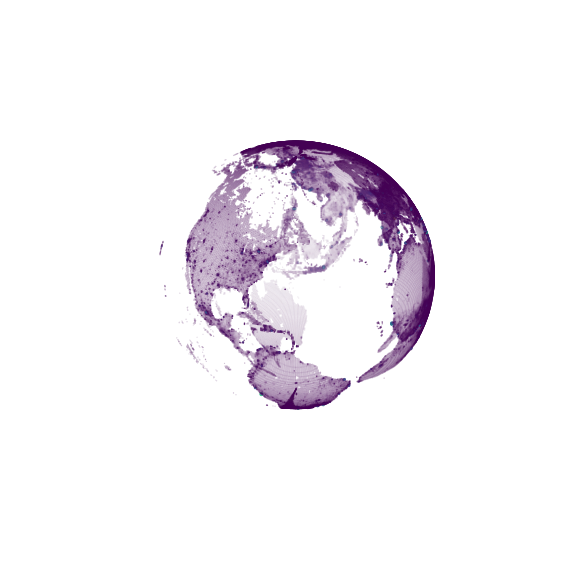

In [94]:
fig = plt.figure() 
ax = fig.add_subplot(111, projection='3d')

x = csv_array_sphere[:,0] 
y = csv_array_sphere[:,1] 
z = csv_array_sphere[:,2] 

ax.scatter(x,y,z, s=0.01 + np.squeeze(csv_array_pop/1000), c=np.squeeze(csv_array_pop))#, cmap=cm.gray)
ax.set_axis_off()

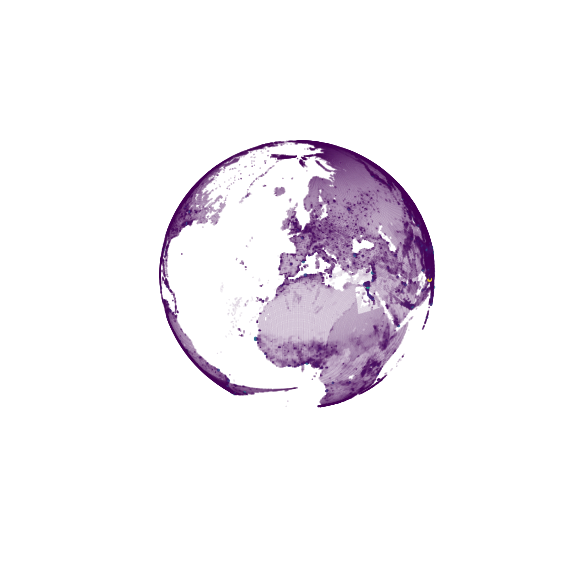

In [95]:
identifier = 'population_sizemod_latPts_'+ str(n_pts_lat)+ '_longPts_' + str(n_pts_long)

directory= 'Z://DataViz//globe//Population//' + identifier + '//' # Set the directory where you would like to export the file.
if not os.path.exists(directory):
    os.makedirs(directory)
fig = plt.figure() 
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x,y,z, s=0.01 + np.squeeze(csv_array_pop/1000), c=np.squeeze(csv_array_pop))#, cmap=cm.gray)

for angle in range(0, 360):
    ax.view_init(30, angle)
    ax.set_axis_off()
    figname=directory+identifier + '_' + str(angle) + '.png'
    plt.savefig(figname)

##### Use 2D histogram-based method to calculate the mean value per bin. 
See sample code here: https://stackoverflow.com/questions/24917685/find-mean-bin-values-using-histogram2d-python